# Predicting ExoPlanet Discoverability based off Planetary Features 
## Phase 2: Statistical Modelling

#### Group Name: 40

#### Name(s) & ID(s) of Group Members:
Rafat Mahiuddin (s3897093)

Adrian Rebellato (s3889401)

## Table of Contents
- [Introduction](#intro)
- [Statistical Modelling](#sm)
- [Critique & Limitations](#cl)
- [Summary & Conclusions](#sc)

## Introduction <a id='intro'></a>

### Phase 1 Summary

A brief yet complete and accurate summary of the work conducted for your Phase 1 report and how they relate to your Phase 2 report. 

**Important Phase 2 Note:** Please do NOT include your Phase 1 report or its contents with your Phase 2 submissions. You can, however, make some changes with your Phase 1 tasks if you need to, and then ONLY include these changes with your Phase 2 report with some explanation for these changes.

### Report Overview

A complete and accurate overview of the contents of your Phase 2 report. Clarification: A Table of Contents is not a report overview.

### Overview of Methodology

A detailed, complete, and accurate overview of your statistical modelling methodology (which is multiple linear regression).

## Data Processing

### Module Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import patsy

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

df = pd.read_csv('Phase2_Group40.csv')
print('Before Rename:', df.columns.to_list())

# Rename columns to be compatible with patsy
df.rename({'semi-major_axis': 'semi_major_axis', '2_stars': 'two_stars'}, axis=1, inplace=True)
print("After Rename:")
df.head()

Before Rename: ['num_star', '2_stars', 'orbital_period', 'semi-major_axis', 'planet_radius', 'planet_mass', 'planet_eccen', 'planet_temp', 'star_temp', 'star_radius', 'star_mass', 'star_bright', 'star_age', 'latitude_gal', 'longitude_gal', 'distance', 'parallax', 'mass_ratio_sys', 'radius_ratio_sys', 'num_planet']
After Rename:


,num_star,two_stars,orbital_period,semi_major_axis,planet_radius,planet_mass,planet_eccen,planet_temp,star_temp,star_radius,star_mass,star_bright,star_age,latitude_gal,longitude_gal,distance,parallax,mass_ratio_sys,radius_ratio_sys,num_planet
0,3,0,11688.000000,12.00000,13.400,635.6600,0.45,700.0,7295.0,1.49,1.65,0.752,0.020,-30.65764,198.61297,29.7575,33.5770,0.001157,0.082282,1
1,2,0,14.651600,0.11340,13.900,263.9785,0.00,700.0,5172.0,0.94,0.91,-0.197,5.500,37.69663,196.79526,12.5855,79.4274,0.000871,0.135292,5
2,2,0,0.736547,0.01544,1.875,7.9900,0.05,1958.0,5172.0,0.94,0.91,-0.197,10.200,37.69663,196.79526,12.5855,79.4274,0.000026,0.018250,5
3,1,0,8.463000,0.06450,4.070,17.0000,0.00,593.0,3700.0,0.75,0.50,-1.046,0.022,-36.80401,12.65304,9.7221,102.8290,0.000102,0.049650,2
4,1,0,18.859019,0.11010,3.240,13.6000,0.00,454.0,3700.0,0.75,0.50,-1.065,0.022,-36.80401,12.65304,9.7221,102.8290,0.000082,0.039525,2


### One Hot Encoding

In [ ]:
# Generate a copy for data modification
data_encoded = df.copy()

In [ ]:
categorical_vars = [ "num_star", "two_stars", "num_planet"]

for var in categorical_vars:
    data_encoded = data_encoded.astype({var: object})

# Categorical encoding for less than 2 values
for col in data_encoded.columns:
    q = len(data_encoded[col].unique())
    if (q == 2):
        data_encoded[col] = pd.get_dummies(data_encoded[col], drop_first=True)
# For categorical features > 2 levels
data_encoded = pd.get_dummies(data_encoded)

print(f"There are {data_encoded.shape[1]} columns with the column names {data_encoded.columns.to_list()} after one hot encoding")

There are 30 columns with the column names ['two_stars', 'orbital_period', 'semi_major_axis', 'planet_radius', 'planet_mass', 'planet_eccen', 'planet_temp', 'star_temp', 'star_radius', 'star_mass', 'star_bright', 'star_age', 'latitude_gal', 'longitude_gal', 'distance', 'parallax', 'mass_ratio_sys', 'radius_ratio_sys', 'num_star_1', 'num_star_2', 'num_star_3', 'num_star_4', 'num_planet_1', 'num_planet_2', 'num_planet_3', 'num_planet_4', 'num_planet_5', 'num_planet_6', 'num_planet_7', 'num_planet_8'] after one hot encoding


### Data Normalisation

In [ ]:
"""
Due to the nature of our dataset, all uint8 types are considered categorical.
"""
# Perform normalisation on only the float types in df_float.
df_float = data_encoded.select_dtypes(include=['float64'])
df_float.drop('planet_radius', inplace=True, axis=1)
print(df_float.columns.to_list())
# TODO: Check if RobustScaler gives out better results
df_norm = MinMaxScaler().fit_transform(df_float)

print(f"The mean of each column in the df_norm dataframe is {np.round(df_norm.mean(axis=0),3)}")

['orbital_period', 'semi_major_axis', 'planet_mass', 'planet_eccen', 'planet_temp', 'star_temp', 'star_radius', 'star_mass', 'star_bright', 'star_age', 'latitude_gal', 'longitude_gal', 'distance', 'parallax', 'mass_ratio_sys', 'radius_ratio_sys']
The mean of each column in the df_norm dataframe is [0.001 0.005 0.005 0.029 0.204 0.388 0.164 0.328 0.69  0.301 0.536 0.278
 0.157 0.016 0.005 0.004]


In [ ]:
data_encoded.loc[:, 
        ['orbital_period', 'semi_major_axis', 'planet_mass', 'planet_eccen',
         'planet_temp', 'star_temp', 'star_radius', 'star_mass', 'star_bright',
         'star_age', 'latitude_gal', 'longitude_gal', 'distance', 'parallax',
         'mass_ratio_sys', 'radius_ratio_sys'
        ]
        ] = pd.DataFrame(df_norm, columns=[
                                            'orbital_period', 'semi_major_axis', 
                                            'planet_mass', 'planet_eccen',
                                            'planet_temp', 'star_temp',
                                            'star_radius', 'star_mass',
                                            'star_bright', 'star_age',
                                            'latitude_gal', 'longitude_gal',
                                            'distance', 'parallax',
                                            'mass_ratio_sys', 'radius_ratio_sys'
                                            ])
data_encoded.sample(3)

,two_stars,orbital_period,semi_major_axis,planet_radius,planet_mass,planet_eccen,planet_temp,star_temp,star_radius,star_mass,star_bright,star_age,latitude_gal,longitude_gal,distance,parallax,mass_ratio_sys,radius_ratio_sys,num_star_1,num_star_2,num_star_3,num_star_4,num_planet_1,num_planet_2,num_planet_3,num_planet_4,num_planet_5,num_planet_6,num_planet_7,num_planet_8
424,0,0.001777,0.012026,3.01,0.000216,0.0,0.051210,0.390189,0.139905,0.319703,0.670431,0.231429,0.559804,0.228725,0.108520,0.007116,0.000236,0.002893,1,0,0,0,1,0,0,0,0,0,0,0
634,0,0.000107,0.001769,1.47,0.000064,0.0,0.179618,0.388085,0.141494,0.312268,0.665298,0.334286,0.570219,0.210237,0.165129,0.004823,0.000071,0.001211,1,0,0,0,1,0,0,0,0,0,0,0
2513,0,0.000908,0.007791,2.53,0.000161,0.0,0.085860,0.409784,0.152623,0.330855,0.767454,0.342143,0.560089,0.199260,0.304916,0.002798,0.000170,0.002148,1,0,0,0,0,1,0,0,0,0,0,0


## Statistical Modelling <a id='sm'></a>

### Model Overview

Overview of full model, including the variables and terms you are using in your regression model.

### Model Fitting

Details of assumptions check, model selection, plots of residuals, and technical analysis of regression results.

**NOTE:** The second half of [this](https://github.com/vaksakalli/stats_tutorials/blob/master/Regression_Case_Study1_web.ipynb) regression case study ("Statistical Modeling and Performance Evaluation" Section) will be **very helpful** for this Model Fitting section.

#### Feature Selection

##### Formula String

In [ ]:
formula_string_indep_vars_encoded = ' + '.join(data_encoded.drop(columns='planet_radius').columns)
formula_string_encoded = 'planet_radius ~ ' + formula_string_indep_vars_encoded
print('formula_string_encoded: ', formula_string_encoded)

formula_string_encoded:  planet_radius ~ two_stars + orbital_period + semi_major_axis + planet_mass + planet_eccen + planet_temp + star_temp + star_radius + star_mass + star_bright + star_age + latitude_gal + longitude_gal + distance + parallax + mass_ratio_sys + radius_ratio_sys + num_star_1 + num_star_2 + num_star_3 + num_star_4 + num_planet_1 + num_planet_2 + num_planet_3 + num_planet_4 + num_planet_5 + num_planet_6 + num_planet_7 + num_planet_8


OLS model to encoded data

In [ ]:
model_full = sm.formula.ols(formula=formula_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:          planet_radius   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     122.7
Date:                Tue, 19 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:35:44   Log-Likelihood:                -7449.3
No. Observations:                2895   AIC:                         1.495e+04
Df Residuals:                    2867   BIC:                         1.512e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.7988      0.921  

You can use the code below to to perform backward feature selection using p-values ([credit](https://github.com/vaksakalli/stats_tutorials/blob/master/Regression_Case_Study1_web.ipynb)).

In [ ]:
## create the patsy model description from formula
patsy_description = patsy.ModelDesc.from_formula(formula_string_encoded)

# initialize feature-selected fit to full model
linreg_fit = model_full_fitted

# do backwards elimination using p-values
p_val_cutoff = 0.05

## WARNING 1: The code below assumes that the Intercept term is present in the model.
## WARNING 2: It will work only with main effects and two-way interactions, if any.

print('\nPerforming backwards feature selection using p-values:')

while True:

    # uncomment the line below if you would like to see the regression summary
    # in each step:
    # print(linreg_fit.summary())

    pval_series = linreg_fit.pvalues.drop(labels='Intercept')
    pval_series = pval_series.sort_values(ascending=False)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    term_components = term.split(':')
    print(f'\nRemoving term "{term}" with p-value {pval:.4}')
    if (len(term_components) == 1): ## this is a main effect term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0])]))    
    else: ## this is an interaction term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0]), 
                                                        patsy.EvalFactor(term_components[1])]))    
        
    linreg_fit = smf.ols(formula=patsy_description, data=data_encoded).fit()
    
###
## this is the clean fit after backwards elimination
model_reduced_fitted = smf.ols(formula=patsy_description, data=data_encoded).fit()
###
    
#########
print("\n***")
print(model_reduced_fitted.summary())
print("***")
print(f"Regression number of terms: {len(model_reduced_fitted.model.exog_names)}")
print(f"Regression F-distribution p-value: {model_reduced_fitted.f_pvalue:.4f}")
print(f"Regression R-squared: {model_reduced_fitted.rsquared:.4f}")
print(f"Regression Adjusted R-squared: {model_reduced_fitted.rsquared_adj:.4f}")


Performing backwards feature selection using p-values:

Removing term "mass_ratio_sys" with p-value 0.9162

Removing term "num_star_3" with p-value 0.803

Removing term "num_star_4" with p-value 0.7509

Removing term "star_bright" with p-value 0.734

Removing term "num_planet_2" with p-value 0.4691

Removing term "num_planet_3" with p-value 0.6848

Removing term "num_planet_5" with p-value 0.3718

Removing term "num_planet_7" with p-value 0.2592

Removing term "num_star_1" with p-value 0.2365

Removing term "num_planet_8" with p-value 0.1993

Removing term "two_stars" with p-value 0.137

Removing term "num_planet_6" with p-value 0.1358

Removing term "star_age" with p-value 0.1502

Removing term "num_planet_4" with p-value 0.08209

***
                            OLS Regression Results                            
Dep. Variable:          planet_radius   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.531
Method:         

#### Calculating Residuals for model visualization

In [ ]:
residuals_full = pd.DataFrame({'actual': df['planet_radius'], 
                            'predicted': model_full_fitted.fittedvalues, 
                            'residual': model_full_fitted.resid})

residuals_reduced = pd.DataFrame({'actual': df['planet_radius'], 
                            'predicted': model_reduced_fitted.fittedvalues, 
                            'residual': model_reduced_fitted.resid})

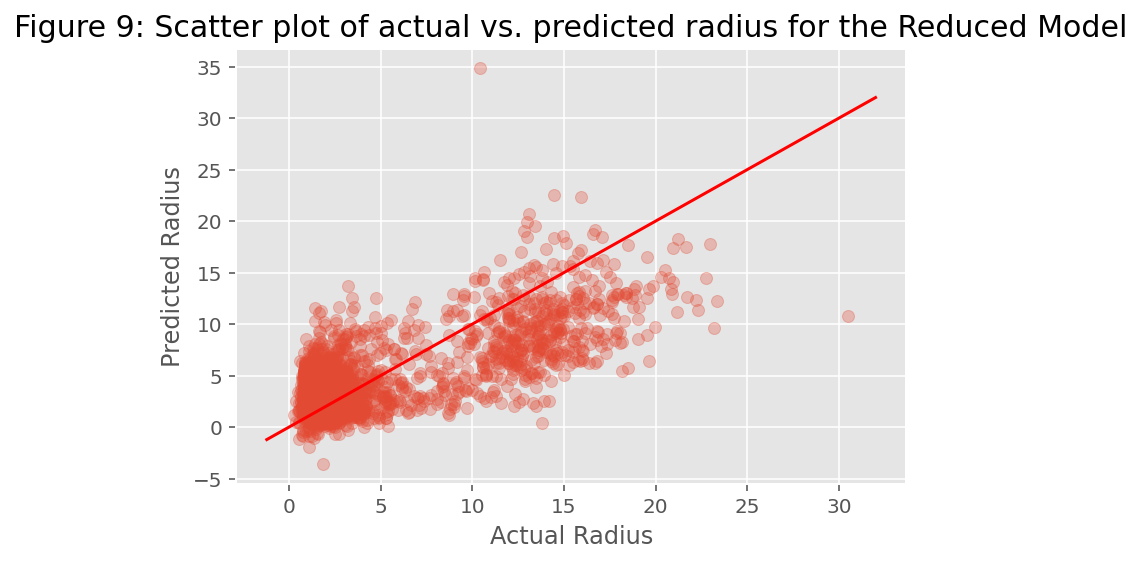

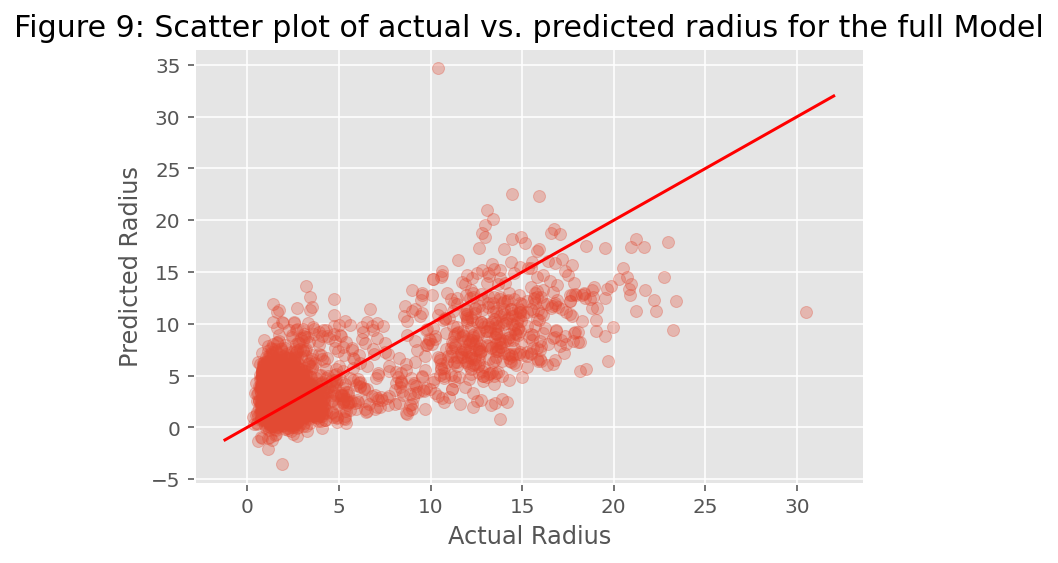

In [ ]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot for reduced model
plt.scatter(residuals_reduced['actual'], residuals_reduced['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Radius');
plt.ylabel('Predicted Radius');
plt.title('Figure 9: Scatter plot of actual vs. predicted radius for the Reduced Model', fontsize=15);
plt.show();

plt.scatter(residuals_full['actual'], residuals_full['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Radius');
plt.ylabel('Predicted Radius');
plt.title('Figure 9: Scatter plot of actual vs. predicted radius for the full Model', fontsize=15);
plt.show();

## Critique & Limitations <a id='cl'></a>

Critique & Limitations of your approach: strengths and weaknesses in detail.

## Summary & Conclusions <a id='sc'></a>

### Project Summary

A comprehensive summary of your entire project (both Phase 1 and Phase 2). That is, what exactly did you do in your project? (Example: I first cleaned the data in such and such ways. And then I applied multiple linear regression techniques in such and such ways. etc).

### Summary of Findings

A comprehensive summary of your findings. That is, what exactly did you find about your particular problem?

### Conclusions

Your detailed conclusions as they relate to your goals and objectives.